# Import Libraries

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta  # technical analysis library
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Flatten
from keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall


In [55]:
raw_SPY_intraday_cleaned_df = pd.read_csv("..\Data\SPY_intraday_cleaned.csv")

In [56]:
raw_SPY_intraday_cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949261 entries, 0 to 949260
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   timestamp_utc  949261 non-null  object 
 1   open           949261 non-null  float64
 2   high           949261 non-null  float64
 3   low            949261 non-null  float64
 4   close          949261 non-null  float64
 5   volume         949261 non-null  float64
 6   timestamp_ny   949261 non-null  object 
 7   ret            949261 non-null  float64
 8   vol_5m         949261 non-null  float64
 9   vol_30m        949260 non-null  float64
 10  abs_ret        949261 non-null  float64
dtypes: float64(9), object(2)
memory usage: 79.7+ MB


# Feature Preprocessing

## Add features

In [57]:
# Copy dataset
SPY_intraday_cleaned_df = raw_SPY_intraday_cleaned_df.copy()

# Time format
SPY_intraday_cleaned_df['timestamp_utc'] = pd.to_datetime(SPY_intraday_cleaned_df['timestamp_utc'])
SPY_intraday_cleaned_df = SPY_intraday_cleaned_df.set_index('timestamp_utc').sort_index()


price_cols = ['open', 'high', 'low', 'close', 'volume']

# Momentum
SPY_intraday_cleaned_df['log_ret'] = np.log(SPY_intraday_cleaned_df['close'] / SPY_intraday_cleaned_df['close'].shift(1))

# Rolling returns
SPY_intraday_cleaned_df['ret_15m'] = SPY_intraday_cleaned_df['close'].pct_change(3)   # assuming 5min data → 3 intervals = 15min
SPY_intraday_cleaned_df['ret_30m'] = SPY_intraday_cleaned_df['close'].pct_change(6)

# Volatility
SPY_intraday_cleaned_df['vol_15m'] = SPY_intraday_cleaned_df['log_ret'].rolling(3).std()
SPY_intraday_cleaned_df['vol_60m'] = SPY_intraday_cleaned_df['log_ret'].rolling(12).std()

# Trend
SPY_intraday_cleaned_df['MA_short'] = SPY_intraday_cleaned_df['close'].rolling(12).mean()   # 1 hour
SPY_intraday_cleaned_df['MA_long'] = SPY_intraday_cleaned_df['close'].rolling(60).mean()    # 5 hours
SPY_intraday_cleaned_df['MA_ratio'] = SPY_intraday_cleaned_df['MA_short'] / SPY_intraday_cleaned_df['MA_long']   # relative trend

# Technical Indicators
SPY_intraday_cleaned_df['MACD'] = ta.trend.macd(SPY_intraday_cleaned_df['close'])
SPY_intraday_cleaned_df['RSI'] = ta.momentum.rsi(SPY_intraday_cleaned_df['close'], window=14)
SPY_intraday_cleaned_df['ATR'] = ta.volatility.average_true_range(SPY_intraday_cleaned_df['high'], SPY_intraday_cleaned_df['low'], SPY_intraday_cleaned_df['close'], window=14)


# Time features
SPY_intraday_cleaned_df['hour'] = SPY_intraday_cleaned_df.index.hour
SPY_intraday_cleaned_df['dayofweek'] = SPY_intraday_cleaned_df.index.dayofweek

SPY_intraday_cleaned_df['hour_sin'] = np.sin(2 * np.pi * SPY_intraday_cleaned_df['hour'] / 24)
SPY_intraday_cleaned_df['hour_cos'] = np.cos(2 * np.pi * SPY_intraday_cleaned_df['hour'] / 24)
SPY_intraday_cleaned_df['dow_sin'] = np.sin(2 * np.pi * SPY_intraday_cleaned_df['dayofweek'] / 7)
SPY_intraday_cleaned_df['dow_cos'] = np.cos(2 * np.pi * SPY_intraday_cleaned_df['dayofweek'] / 7)

SPY_intraday_cleaned_df


,open,high,low,close,volume,timestamp_ny,ret,vol_5m,vol_30m,abs_ret,...,MA_ratio,MACD,RSI,ATR,hour,dayofweek,hour_sin,hour_cos,dow_sin,dow_cos
timestamp_utc,,,,,,,,,,,,,,,,,,,,,
2024-01-02 15:00:00+00:00,472.275,472.600,472.135,472.460,414610.0,2024-01-02 10:00:00-05:00,0.000402,0.000315,NaN,0.000402,...,NaN,NaN,NaN,0.000000,15,1,-0.707107,-0.707107,0.781831,0.623490
2024-01-02 15:01:00+00:00,472.460,472.540,472.370,472.540,203703.0,2024-01-02 10:01:00-05:00,0.000169,0.000181,0.000165,0.000169,...,NaN,NaN,NaN,0.000000,15,1,-0.707107,-0.707107,0.781831,0.623490
2024-01-02 15:02:00+00:00,472.540,472.631,472.470,472.515,161592.0,2024-01-02 10:02:00-05:00,-0.000053,0.000274,0.000228,0.000053,...,NaN,NaN,NaN,0.000000,15,1,-0.707107,-0.707107,0.781831,0.623490
2024-01-02 15:03:00+00:00,472.540,472.710,472.500,472.580,127841.0,2024-01-02 10:03:00-05:00,0.000138,0.000251,0.000187,0.000138,...,NaN,NaN,NaN,0.000000,15,1,-0.707107,-0.707107,0.781831,0.623490
2024-01-02 15:04:00+00:00,472.570,472.620,472.460,472.556,225236.0,2024-01-02 10:04:00-05:00,-0.000051,0.000188,0.000188,0.000051,...,NaN,NaN,NaN,0.000000,15,1,-0.707107,-0.707107,0.781831,0.623490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-22 19:56:00+00:00,667.730,668.080,667.700,667.960,266965.0,2025-10-22 15:56:00-04:00,0.000359,0.000365,0.000306,0.000359,...,1.000696,0.099081,55.717839,0.338752,19,2,-0.965926,0.258819,0.974928,-0.222521
2025-10-22 19:57:00+00:00,667.970,667.970,667.500,667.560,426714.0,2025-10-22 15:57:00-04:00,-0.000599,0.000387,0.000325,0.000599,...,1.000675,0.071025,47.097785,0.348127,19,2,-0.965926,0.258819,0.974928,-0.222521
2025-10-22 19:58:00+00:00,667.550,667.630,667.410,667.520,600191.0,2025-10-22 15:58:00-04:00,-0.000060,0.000363,0.000307,0.000060,...,1.000628,0.045045,46.325949,0.338975,19,2,-0.965926,0.258819,0.974928,-0.222521


# Create Target Variable

In [58]:
# Define future return over next 5-minute window
SPY_intraday_cleaned_df['future_ret_5m'] = (
    SPY_intraday_cleaned_df['close'].shift(-5) / SPY_intraday_cleaned_df['close'] - 1
)

pos_thresh = 0.0003   # +0.03%

SPY_intraday_cleaned_df['y_next5_up'] = (
    SPY_intraday_cleaned_df['future_ret_5m'] > pos_thresh
).astype(int)

# Drop rows where future return cannot be computed (the last 5 rows)
SPY_intraday_cleaned_df = SPY_intraday_cleaned_df.dropna(subset=['future_ret_5m'])


In [59]:
SPY_intraday_cleaned_df["y_next5_up"]

timestamp_utc
2024-01-02 15:00:00+00:00    0
2024-01-02 15:01:00+00:00    0
2024-01-02 15:02:00+00:00    0
2024-01-02 15:03:00+00:00    0
2024-01-02 15:04:00+00:00    0
                            ..
2025-10-22 19:51:00+00:00    0
2025-10-22 19:52:00+00:00    0
2025-10-22 19:53:00+00:00    0
2025-10-22 19:54:00+00:00    0
2025-10-22 19:55:00+00:00    1
Name: y_next5_up, Length: 949256, dtype: int32

In [60]:
counts = SPY_intraday_cleaned_df['y_next5_up'].value_counts()
percentages = 100 * counts / counts.sum()
print(pd.DataFrame({'Count': counts, 'Percentage': percentages}))


             Count  Percentage
y_next5_up                    
0           897712   94.570063
1            51544    5.429937


In [61]:
future_ret = SPY_intraday_cleaned_df['future_ret_5m']
print(future_ret.describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))


count    949256.000000
mean          0.000002
std           0.000498
min          -0.041088
1%           -0.001223
5%           -0.000301
10%           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
90%           0.000000
95%           0.000338
99%           0.001168
max           0.045386
Name: future_ret_5m, dtype: float64


# Feature Selection

In [62]:
feature_cols = [
    'volume',
    'ret', 'log_ret', 'ret_15m', 'ret_30m', 'abs_ret',
    'vol_5m', 'vol_15m', 'vol_30m', 'vol_60m',
    'MA_ratio', 'MACD', 'RSI', 'ATR',
    'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos'
]

target_col = 'y_next5_up'

# Train test split

In [63]:
# Ensure index is datetime and sorted
SPY_intraday_cleaned_df = SPY_intraday_cleaned_df.sort_index()
dates = SPY_intraday_cleaned_df.index

# Define chronological cut-offs
train_end = '2025-04-30'
val_end   = '2025-08-31'

train_df = SPY_intraday_cleaned_df.loc[:train_end]
val_df   = SPY_intraday_cleaned_df.loc[train_end:val_end]
test_df  = SPY_intraday_cleaned_df.loc[val_end:]

print(f"Train: {train_df.index.min()} → {train_df.index.max()}  ({len(train_df)} samples)")
print(f"Val:   {val_df.index.min()} → {val_df.index.max()}  ({len(val_df)} samples)")
print(f"Test:  {test_df.index.min()} → {test_df.index.max()}  ({len(test_df)} samples)")


Train: 2024-01-02 15:00:00+00:00 → 2025-04-30 23:59:00+00:00  (697500 samples)
Val:   2025-04-30 00:00:00+00:00 → 2025-08-31 23:59:00+00:00  (178560 samples)
Test:  2025-08-31 00:00:00+00:00 → 2025-10-22 19:55:00+00:00  (76076 samples)


Split around major volatility regime shifts (e.g., high-vol periods vs stable).

# Feature Preprocessing

## Scale numeric features

In [64]:
scaler = StandardScaler()
scaler.fit(train_df[feature_cols])

# Transform each split
train_df.loc[:, feature_cols] = scaler.transform(train_df[feature_cols])
val_df.loc[:, feature_cols]   = scaler.transform(val_df[feature_cols])
test_df.loc[:, feature_cols]  = scaler.transform(test_df[feature_cols])


## Create lookback window

In [65]:
def make_sequences(df, feature_cols, target_col, lookback=60):
    X, y = [], []
    data = df[feature_cols].values
    labels = df[target_col].values

    for i in range(lookback, len(df)):
        X.append(data[i - lookback:i])
        y.append(labels[i])

    return np.array(X), np.array(y)

# Create rolling sequences
lookback = 60  # 60 timesteps = past 60 minutes
target_col = 'y_next5_up'

X_train, y_train = make_sequences(train_df, feature_cols, target_col, lookback)
X_val, y_val     = make_sequences(val_df,   feature_cols, target_col, lookback)
X_test, y_test   = make_sequences(test_df,  feature_cols, target_col, lookback)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (697440, 60, 18), Val: (178500, 60, 18), Test: (76016, 60, 18)


# Model Architecture

In [68]:
def build_cnn_lstm(input_shape):
    model = Sequential([
        # CNN feature extractor
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),

        # Temporal modeling (LSTM)
        LSTM(64, return_sequences=False),
        Dropout(0.2),

        # Fully connected classifier
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(1, activation='sigmoid')   # Binary classificatioan
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=1e-4),
         metrics=[
            AUC(name='auc'),
            Precision(name='precision'),
            Recall(name='recall')
        ]
    )
    return model


input_shape = (X_train.shape[1], X_train.shape[2])

model = build_cnn_lstm(input_shape)
model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 60, 64)            3520      
                                                                 
 batch_normalization_2 (Bat  (None, 60, 64)            256       
 chNormalization)                                                
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 30, 64)            0         
 g1D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 30, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_7 (Dropout)         (None, 64)               

# Train Baseline Model

In [69]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,          # stop after 3 epochs with no improvement
    restore_best_weights=True
)

In [70]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,           
    batch_size=256,      
    verbose=1,
    callbacks=[early_stop]
)
 

Epoch 1/50
2725/2725 [==============================] - 89s 32ms/step - loss: 0.6368 - auc: 0.4995 - precision: 0.0676 - recall: 0.0028 - val_loss: 0.5832 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
2725/2725 [==============================] - 86s 32ms/step - loss: 0.5382 - auc: 0.5024 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4931 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
2725/2725 [==============================] - 88s 32ms/step - loss: 0.4574 - auc: 0.5018 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4192 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
2725/2725 [==============================] - 87s 32ms/step - loss: 0.3918 - auc: 0.4992 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3597 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
2725/2725 [==============================] - 87s 32ms/step - 

In [72]:
print(f"Final training AUC: {history.history['auc'][-1]:.4f}")
print(f"Final validation AUC: {history.history['val_auc'][-1]:.4f}")

print(f"Final training Precision: {history.history['precision'][-1]:.4f}")
print(f"Final validation Precision: {history.history['val_precision'][-1]:.4f}")

print(f"Final training Recall: {history.history['recall'][-1]:.4f}")
print(f"Final validation Recall: {history.history['val_recall'][-1]:.4f}")


Final training AUC: 0.5000
Final validation AUC: 0.5000
Final training Precision: 0.0000
Final validation Precision: 0.0000
Final training Recall: 0.0000
Final validation Recall: 0.0000


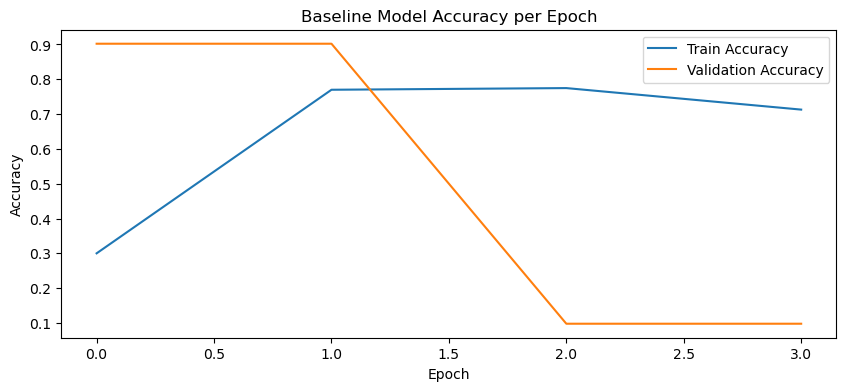

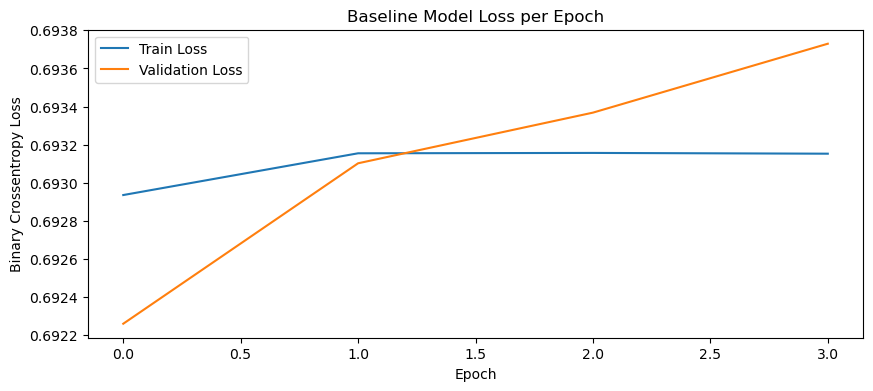

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Baseline Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Baseline Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()
plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")


2376/2376 [==============================] - 6s 3ms/step - loss: 0.6922 - accuracy: 0.9020
✅ Test Accuracy: 0.9020
✅ Test Loss: 0.6922


In [ ]:
# Predict probabilities of upward move
y_prob = model.predict(X_test, verbose=0).ravel()

In [ ]:
import numpy as np
print("Min prob:", np.min(y_prob))
print("Max prob:", np.max(y_prob))
print("Mean prob:", np.mean(y_prob))
print("Unique (rounded):", np.unique(np.round(y_prob, 2))[:20])


Min prob: 0.49944657
Max prob: 0.49944657
Mean prob: 0.49944645
Unique (rounded): [0.5]


AUC Score: 0.5000


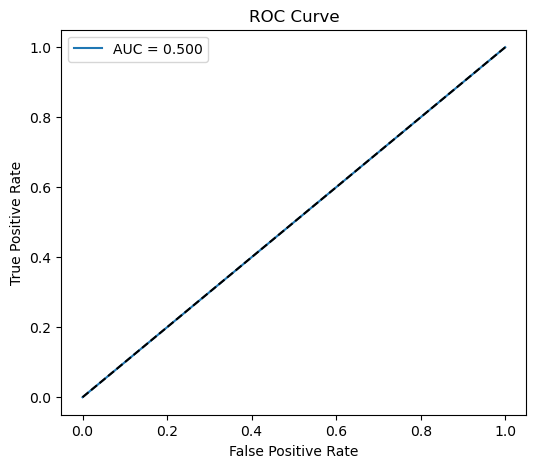

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

# Compute AUC
auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC Score: {auc_score:.4f}")

# Optional: Plot ROC curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
